# K-Means++ from Scratch
***
## Table of Contents
1. Standard K-Means Model
2. K-Means++ Model
3. Visualising Results
4. Experiments
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray
from typing import List, Dict, Optional
from sklearn.datasets import make_blobs, make_circles
HistoryType = List[Dict[str, NDArray[np.float64] | NDArray[np.int64]]]

This notebook is an extension of [K-Means Clustering from Scratch](https://github.com/tsu76i/DS-playground/blob/main/2.%20Building%20ML%20Models%20From%20Scratch/2.5%20KMeans/k_means.ipynb).

In the previous exercise, we developed a standard K-Means clustering algorithm from scratch. While effective in many scenarios, the standard K-Means algorithm initialises cluster centroids with a random number, which can lead to suboptimal clustering results. If the initial centroids are far from optimal, the algorithm may converge to a solution that does not reflect the actual data distribution. Furthermore, as the algorithm computes the mean value to find centroids, it is sensive to outlieres and a few extreme values can significantly distort the centroid positions.

To handle these limitations, K-Means++ introduces a more sophisticated method for initialising centroids:

1. Improved Initialisation
- K-Means selects initial centroids in a way that ensures they are well-dispersed across the feature space, reducing the likelihood of poor clustering results.
- The process begins by randomly selecting the first centroid from the data points. Each subsequent centroid is then chosen from the remaining data points with a probability proportional to the squared distance from the nearest already-selected centroid. This probabilistic selection favours points that are farther from existing centroids, promoting greater separation between clusters.

2. Faster Convergence
- By initialising centroids more strategically, K-Means++ typically reduces the number of iterations required for the algorithm to converge. This not only accelerates the clustering process but also decreases computational cost.

3. Enhanced Clustering Accuracy
- The improved initialisation method of K-Means++ helps avoid poor local minima, resulting in clusters with lower within-cluster variance (distortion) and a better representation of the data structure.

## 1. Standard K-Means Model

In [2]:
class CustomKMeans:
    """
    Custom implementation of the K-Means clustering algorithm with vectorised operations.

    Attributes:
    - n_clusters (int): Number of clusters.
    - max_iters (int): Maximum number of iterations.
    - tol (float): Convergence tolerance for centroid shifts.
    - random_state (int): Seed for random number generator.
    - disp_conv (bool): Whether to display convergence messages.
    - centroids (Optional[NDArray[np.float64]]): Final cluster centroids.
    - labels (Optional[NDArray[np.int64]]): Cluster labels for input data.
    - history (Optional[HistoryType]): History of centroids and labels during fitting.
    - n_iter_ (int): Number of iterations performed.
    """

    def __init__(self, n_clusters: int, max_iters: int = 100, tol: float = 1e-4, random_state: int = 42, disp_conv=False):
        """
        Initialise the K-Means model with specified parameters.

        Args:
        - n_clusters (int): Number of clusters.
        - max_iters (int): Maximum number of iterations. Default is 100.
        - tol (float): Convergence tolerance for centroid shifts. Default is 1e-4.
        - random_state (int): Seed for random number generator. Default is 42.
        - disp_conv (bool): Whether to display convergence messages. Default is False.
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.rng = np.random.default_rng(random_state)
        self.centroids: Optional[NDArray[np.float64]] = None
        self.labels: Optional[NDArray[np.int64]] = None
        self.history: Optional[HistoryType] = None
        self.disp_conv = disp_conv
        self.n_iter_ = 0

    def _calculate_euclidean(self, X: NDArray[np.float64], centroids: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Calculate the distance between each data point and cluster centroid.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).
        - centroids (NDArray[np.float64]): Current centroids, shape (n_clusters, n_features).

        Returns:
        - distances (NDArray[np.float64]): Distance matrix, shape (n_samples, n_clusters).
        """
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def _initialise_centroids(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Randomly initialise cluster centroids using the data points.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).

        Returns:
        - centroids (NDArray[np.float64]): Initialised centroids, shape (n_clusters, n_features).
        """
        return self.rng.choice(X, size=self.n_clusters, replace=False, axis=0)

    def _update_centroids(self, X: NDArray[np.float64], labels: NDArray[np.int64]) -> NDArray[np.float64]:
        """
        Update the centroids based on the mean of data points in each cluster.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).
        - labels (NDArray[np.int64]): Cluster assignments, shape (n_samples,).

        Returns:
        - new_centroids (NDArray[np.float64]): Updated centroids, shape (n_clusters, n_features).
        """
        new_centroids = np.empty_like(self.centroids)
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            # Avoid failure when clusters become empty
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # Maintain previous position
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def _is_converged(self, old: NDArray[np.float64], new: NDArray[np.float64]) -> bool:
        """
        Check if centroids have converged based on the specified tolerance.

        Args:
        - old (NDArray[np.float64]): Centroids from the previous iteration, shape (n_clusters, n_features).
        - new (NDArray[np.float64]): Current centroids, shape (n_clusters, n_features).

        Returns:
        - bool: True if the centroids have converged, False otherwise.
        """
        return np.all(np.linalg.norm(new - old, axis=1) < self.tol)

    def fit(self, X: NDArray[np.float64]):
        """
        Fit the K-Means model to the data.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).

        Returns:
        - self: Fitted KMeans instance.
        """
        self.centroids = self._initialise_centroids(X)
        self.history = [{'centroids': self.centroids.copy(), 'labels': None}]

        for self.n_iter_ in range(1, self.max_iters + 1):
            distances = self._calculate_euclidean(X, self.centroids)
            labels = np.argmin(distances, axis=1)
            new_centroids = self._update_centroids(X, labels)

            # Store both centroids AND labels at each iteration
            self.history.append({
                'centroids': new_centroids.copy(),
                'labels': labels.copy()
            })

            if self._is_converged(self.centroids, new_centroids):
                if self.disp_conv:
                    print(
                        f"KMeans: Converged after {self.n_iter_} iterations.")
                break

            self.centroids = new_centroids
        self.labels = labels
        return self

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """
        Assign cluster labels to new data points.

        Args:
        - X (NDArray[np.float64]): Data points to cluster, shape (n_samples, n_features).

        Returns:
        - labels (NDArray[np.int64]): Assigned cluster labels, shape (n_samples,).
        """
        if self.centroids is None:
            raise ValueError("Model not fitted. Call fit() first.")
        return np.argmin(self._calculate_euclidean(X, self.centroids), axis=1)

## 2. K-Means++ Model

The only thing we need to modify is the centroid initialisation. In the previous code, $k$ centroids were selected at random. To implement K-Means++ model, replace the code with the following logic:

1. Randomly pick the first centroid from the dataset.
2. For each remaining centroid:
    - Calculate the distance from each point to the nearest already selected centroid.
    - Choose the next centroid with probability proportional to the squared distance:

    \begin{align*}
    P(x) = \dfrac{D(x)^2}{\sum_{x' \in X} D(x')^2}
    \end{align*}
    where $D(x)$ is the distance to the closest centroid.
3. Repeat step 2 until all $k$ centroids are chosen.

In [3]:
def _initialise_centroids(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
    """
    Randomly initialise cluster centroids using the data points.

    Args:
    - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).

    Returns:
    - centroids (NDArray[np.float64]): Initialised centroids, shape (n_clusters, n_features).
    """

    # ! KMeans++ Initialisation
    # Step 1: Randomly select the first centroid
    centroids = [X[self.rng.integers(len(X))]]

    # Step 2: Select the remaining centroids
    for _ in range(1, self.n_clusters):

        # Compute the squared distance from each point to the closest centroid
        distances = np.min(self._calculate_euclidean(
            X, np.array(centroids)), axis=1)

        # Compute probabilities proportional to the squared distances
        probs = distances ** 2 / np.sum(distances ** 2)

        # Select the next centroid based on the probability distribution
        next_centroid_idx = self.rng.choice(len(X), p=probs)
        centroids.append(X[next_centroid_idx])
    return np.array(centroids)

Using this new method for initialising centroids, let's create a new class `CustomKMeansP2`. The rest of the code stays exactly the same as the standard KMeans algorithm.

In [4]:
class CustomKMeansP2:
    """
    Custom implementation of the K-Means clustering algorithm with vectorised operations.

    Attributes:
    - n_clusters (int): Number of clusters.
    - max_iters (int): Maximum number of iterations.
    - tol (float): Convergence tolerance for centroid shifts.
    - random_state (int): Seed for random number generator.
    - disp_conv (bool): Whether to display convergence messages.
    - centroids (Optional[NDArray[np.float64]]): Final cluster centroids.
    - labels (Optional[NDArray[np.int64]]): Cluster labels for input data.
    - history (Optional[HistoryType]): History of centroids and labels during fitting.
    - n_iter_ (int): Number of iterations performed.
    """

    def __init__(self, n_clusters: int, max_iters: int = 100, tol: float = 1e-4, random_state: int = 42, disp_conv=False):
        """
        Initialise the K-Means model with specified parameters.

        Args:
        - n_clusters (int): Number of clusters.
        - max_iters (int): Maximum number of iterations. Default is 100.
        - tol (float): Convergence tolerance for centroid shifts. Default is 1e-4.
        - random_state (int): Seed for random number generator. Default is 42.
        - disp_conv (bool): Whether to display convergence messages. Default is False.
        """
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.rng = np.random.default_rng(random_state)
        self.centroids: Optional[NDArray[np.float64]] = None
        self.labels: Optional[NDArray[np.int64]] = None
        self.history: Optional[HistoryType] = None
        self.disp_conv = disp_conv
        self.n_iter_ = 0

    def _calculate_euclidean(self, X: NDArray[np.float64], centroids: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Calculate the distance between each data point and cluster centroid.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).
        - centroids (NDArray[np.float64]): Current centroids, shape (n_clusters, n_features).

        Returns:
        - distances (NDArray[np.float64]): Distance matrix, shape (n_samples, n_clusters).
        """
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def _initialise_centroids(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Randomly initialise cluster centroids using the data points.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).

        Returns:
        - centroids (NDArray[np.float64]): Initialised centroids, shape (n_clusters, n_features).
        """

        # ! KMeans++ Initialisation
        # Step 1: Randomly select the first centroid
        centroids = [X[self.rng.integers(len(X))]]

        # Step 2: Select the remaining centroids
        for _ in range(1, self.n_clusters):

            # Compute the squared distance from each point to the closest centroid
            distances = np.min(self._calculate_euclidean(
                X, np.array(centroids)), axis=1)

            # Compute probabilities proportional to the squared distances
            probs = distances ** 2 / np.sum(distances ** 2)

            # Select the next centroid based on the probability distribution
            next_centroid_idx = self.rng.choice(len(X), p=probs)
            centroids.append(X[next_centroid_idx])
        return np.array(centroids)

    def _update_centroids(self, X: NDArray[np.float64], labels: NDArray[np.int64]) -> NDArray[np.float64]:
        """
        Update the centroids based on the mean of data points in each cluster.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).
        - labels (NDArray[np.int64]): Cluster assignments, shape (n_samples,).

        Returns:
        - new_centroids (NDArray[np.float64]): Updated centroids, shape (n_clusters, n_features).
        """
        new_centroids = np.empty_like(self.centroids)
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            # Avoid failure when clusters become empty
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # Maintain previous position
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def _is_converged(self, old: NDArray[np.float64], new: NDArray[np.float64]) -> bool:
        """
        Check if centroids have converged based on the specified tolerance.

        Args:
        - old (NDArray[np.float64]): Centroids from the previous iteration, shape (n_clusters, n_features).
        - new (NDArray[np.float64]): Current centroids, shape (n_clusters, n_features).

        Returns:
        - bool: True if the centroids have converged, False otherwise.
        """
        return np.all(np.linalg.norm(new - old, axis=1) < self.tol)

    def fit(self, X: NDArray[np.float64]):
        """
        Fit the K-Means model to the data.

        Args:
        - X (NDArray[np.float64]): Data points, shape (n_samples, n_features).

        Returns:
        - self: Fitted KMeans instance.
        """
        self.centroids = self._initialise_centroids(X)
        self.history = [{'centroids': self.centroids.copy(), 'labels': None}]

        for self.n_iter_ in range(1, self.max_iters + 1):
            distances = self._calculate_euclidean(X, self.centroids)
            labels = np.argmin(distances, axis=1)
            new_centroids = self._update_centroids(X, labels)

            # Store both centroids AND labels at each iteration
            self.history.append({
                'centroids': new_centroids.copy(),
                'labels': labels.copy()
            })

            if self._is_converged(self.centroids, new_centroids):
                if self.disp_conv:
                    print(
                        f"KMeans++: Converged after {self.n_iter_} iterations.")
                break

            self.centroids = new_centroids
        self.labels = labels
        return self

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """
        Assign cluster labels to new data points.

        Args:
        - X (NDArray[np.float64]): Data points to cluster, shape (n_samples, n_features).

        Returns:
        - labels (NDArray[np.int64]): Assigned cluster labels, shape (n_samples,).
        """
        if self.centroids is None:
            raise ValueError("Model not fitted. Call fit() first.")
        return np.argmin(self._calculate_euclidean(X, self.centroids), axis=1)

## 3. Visualising Results

Finally, we need a function to visualise the comparison between the two K-Means algorithms.

In [5]:
def plot_results(X: NDArray[np.float64], labels: List[int], centroids: List[float],
                 title: str, palette: List[str]) -> None:

    # For consistency of cluster colours
    colors = palette.as_hex()
    methods = ["KMeans", "KMeans++"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Iterate over 2 axes and their corresponding cluster results
    for i, ax in enumerate(axes):
        label = labels[i]
        centroid = centroids[i]

        # Scatter data points and centroids
        for cluster in np.unique(label):  # Unique cluster ID
            # Select points in the current cluster
            cluster_mask = (label == cluster)
            cluster_color = colors[cluster]  # Assign a unique colour

            # Data points in the current cluster
            ax.scatter(X[cluster_mask, 0], X[cluster_mask, 1],
                       color=cluster_color, s=30, alpha=0.6, label=f'Cluster {cluster}')

            # Centroid in the current cluster
            ax.scatter(centroid[cluster, 0], centroid[cluster, 1],
                       color=cluster_color, edgecolor='black', marker='*', s=200)

        ax.set_title(f"{methods[i]} Clustering ({title})")
        ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

## 4. Experiments
For our experiments, we'll simulate different scenarios using both K-Means and K-Means++ algorithms. We'll start with a normal dataset featuring a reasonable number of clusters and samples.

In [6]:
k = 4
palette = sns.color_palette('bright', n_colors=k)

### Case 1: Normal Dataset

KMeans: Converged after 8 iterations.
KMeans++: Converged after 3 iterations.


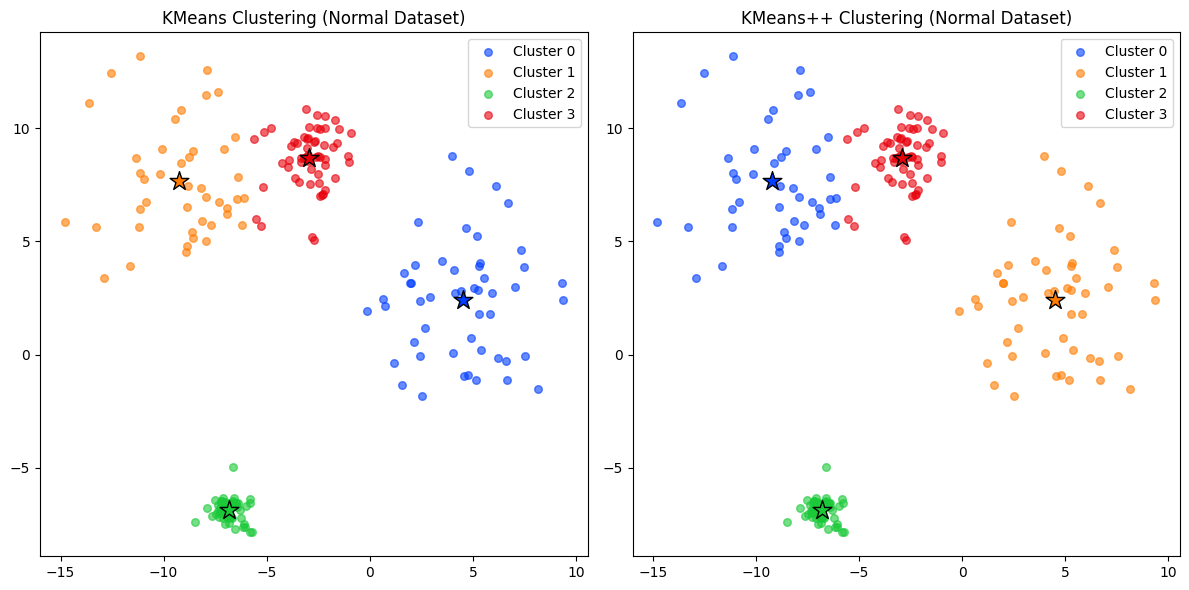

In [7]:
X1, _ = make_blobs(n_samples=200, centers=4, cluster_std=[
                   1.0, 2.5, 0.5, 2.8], random_state=42)

# Instantiate and fit model (Custom KMeans)
kmeans = CustomKMeans(n_clusters=k, disp_conv=True)
kmeans.fit(X1)

# Instantiate and fit model (Custom KMeansP2)
kmeans_p2 = CustomKMeansP2(n_clusters=k, disp_conv=True)
kmeans_p2.fit(X1)

# Store results to lists
labels_list = [kmeans.labels, kmeans_p2.labels]
centroids_list = [kmeans.centroids, kmeans_p2.centroids]

# Visualise
plot_results(X1, labels_list, centroids_list, 'Normal Dataset', palette)

We obtained very similar results in terms of cluster assignments. However, standard K-Means converged after 8 iterations, whereas K-Means++ converged after only 3 iterations. This demonstrates the advantage of K-Means++ for faster convergence due to its more effective centroid initialisation.

### Case 2: Dataset with Varying Cluster Sizes and Densities
Now, let's investigate the case of a dataset with different cluster sizes and densities.

KMeans: Converged after 22 iterations.
KMeans++: Converged after 5 iterations.


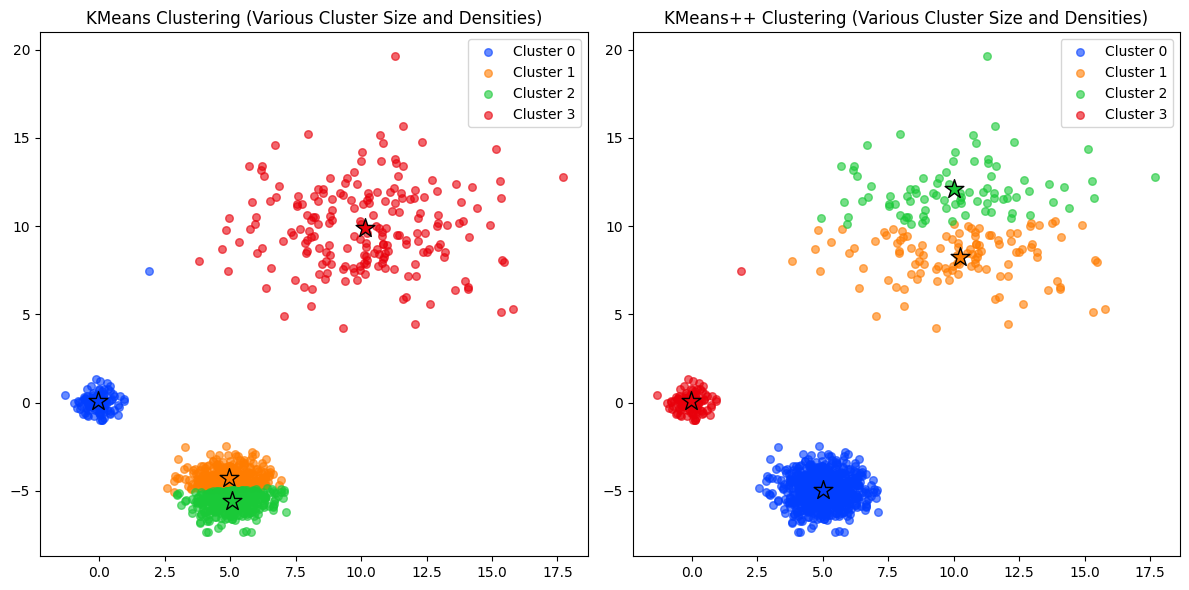

In [8]:
X2, _ = make_blobs(n_samples=[100, 200, 800], centers=[[0, 0], [10, 10], [
    5, -5]], cluster_std=[0.5, 2.5, 0.8], random_state=42)

# Instantiate and fit model (Custom KMeans)
kmeans = CustomKMeans(n_clusters=k, disp_conv=True)
kmeans.fit(X2)

# Instantiate and fit model (Custom KMeansP2)
kmeans_p2 = CustomKMeansP2(n_clusters=k, disp_conv=True)
kmeans_p2.fit(X2)

# Store results to lists
labels_list = [kmeans.labels, kmeans_p2.labels]
centroids_list = [kmeans.centroids, kmeans_p2.centroids]

# Visualise
plot_results(X2, labels_list, centroids_list,
             'Various Cluster Size and Densities', palette)

The standard K-Means algorithm tends to favour clusters of similar size and density due to its random initialisation. As a result, if clusters have imbalanced size or densities, the initialisation of centroids can cause centroids to be placed poorly. In contract, K-Means++ is more likely to place centroids far apart, which typically leads to better separation of clusters and improved clustering performance.

### Case 3: Dataset with Outliers or Noise
K-Means++ also demonstrates improved robustness to outliers and noise.

KMeans: Converged after 7 iterations.
KMeans++: Converged after 6 iterations.


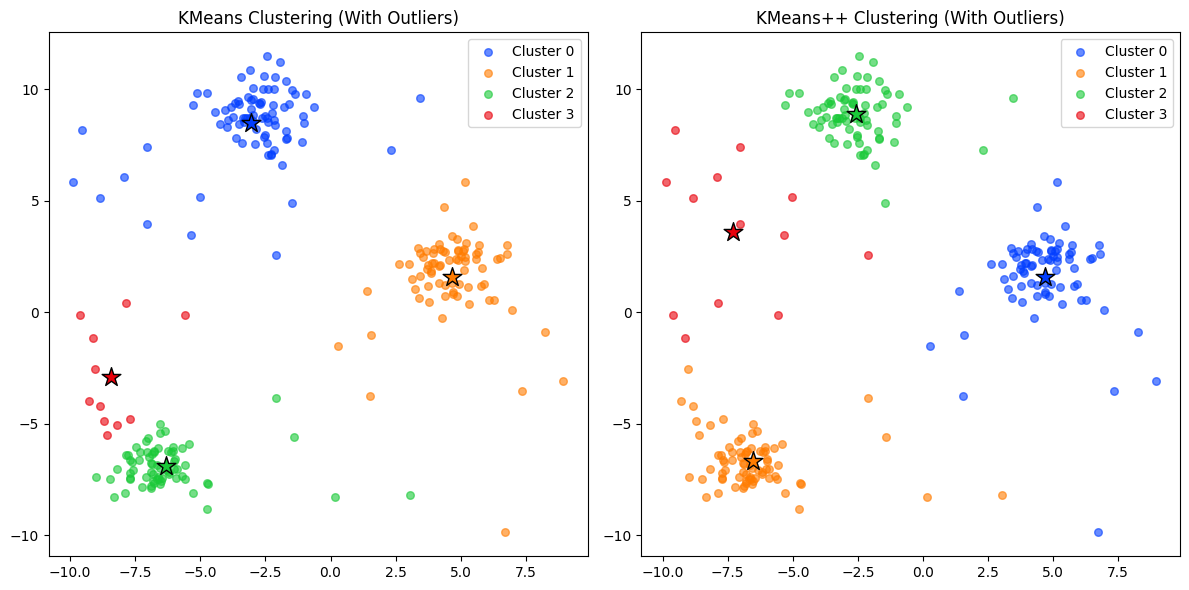

In [9]:
X3, _ = make_blobs(n_samples=200, centers=3, cluster_std=1.0, random_state=42)
rng = np.random.RandomState(46)
X3 = np.vstack([X3, rng.uniform(
    low=-10, high=10, size=(40, 2))])  # Add outliers

# Instantiate and fit model (Custom KMeans)
kmeans = CustomKMeans(n_clusters=k, disp_conv=True)
kmeans.fit(X3)

# Instantiate and fit model (Custom KMeansP2)
kmeans_p2 = CustomKMeansP2(n_clusters=k, disp_conv=True)
kmeans_p2.fit(X3)

# Store results to lists
labels_list = [kmeans.labels, kmeans_p2.labels]
centroids_list = [kmeans.centroids, kmeans_p2.centroids]

# Visualise
plot_results(X3, labels_list, centroids_list, 'With Outliers', palette)

The standard K-Means algorithm is highly sensitive to outliers because centroids are calculated as the mean of the points in each cluster, so a single outlier can significantly shift a centroid. K-Means++ minigates this by reducing the likelihood of selecting initial centroids on or near outliers, resulting in more stable and reliable cluster asssignments compared to the standard one.

### Case 4: Dataset with Non-Spherical Clusters
How about a dataset where clusteres are non-spherical?

KMeans: Converged after 16 iterations.
KMeans++: Converged after 9 iterations.


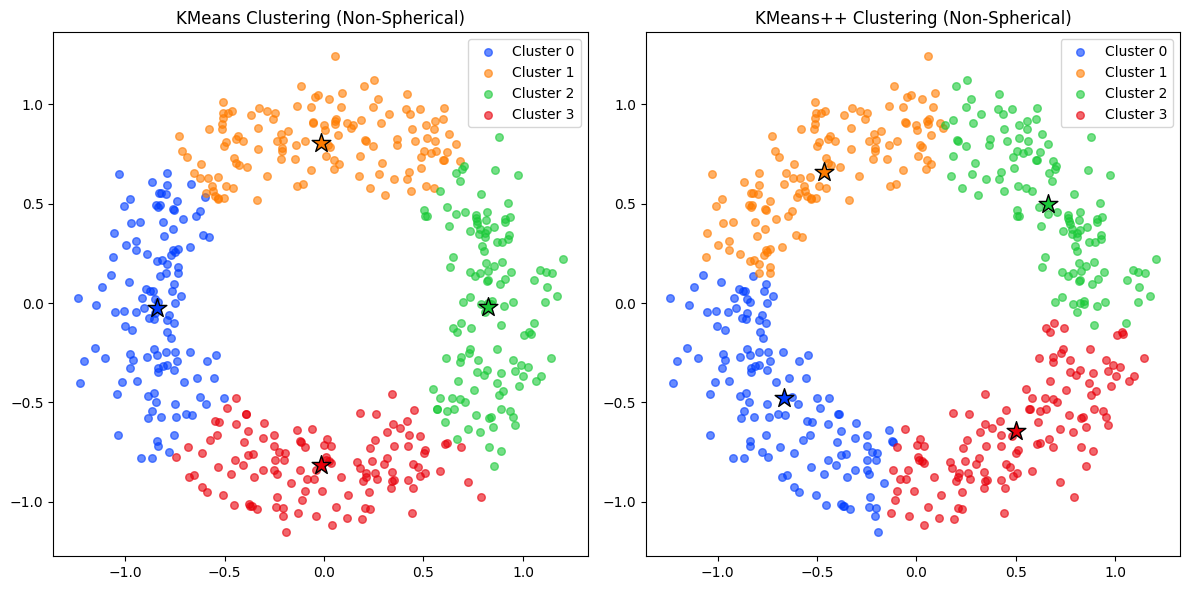

In [10]:
X4, _ = make_circles(
    n_samples=500, factor=0.8, noise=0.1, random_state=55)

# Instantiate and fit model (Custom KMeans)
kmeans = CustomKMeans(n_clusters=k, disp_conv=True)
kmeans.fit(X4)

# Instantiate and fit model (Custom KMeansP2)
kmeans_p2 = CustomKMeansP2(n_clusters=k, disp_conv=True)
kmeans_p2.fit(X4)

# Store results to lists
labels_list = [kmeans.labels, kmeans_p2.labels]
centroids_list = [kmeans.centroids, kmeans_p2.centroids]

# Visualise
plot_results(X4, labels_list, centroids_list, 'Non-Spherical', palette)

Both K-Means and K-Means++ are fundamentally limited when dealing with non-spherical clusters, as the algorithm assumes that clusters are roughly spherical and equally sized. While K-Means++ can improve the initial placement of centroids, leading to potentially faster convergence and better clustering, neither method can fully overcome the limitation imposed by the underlying distance metric and cluster shape assumption. For such data, alternative clustering methods like DBSCAN or spectral clustering can be effective.